In [4]:
%pip install xgboost
%pip install lightgbm

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
import lightgbm as lgb
import xgboost as xgb





In [6]:
df = pd.read_csv('C:\\Users\\04ama\\OneDrive\\chemistry\\ADHD_SEX_Prediction\\notebooks\\EDA\\baseline_dataset.csv')
print(f"Initial dataset shape: {df.shape}")

Initial dataset shape: (1213, 191)



FEATURE CORRELATION ANALYSIS


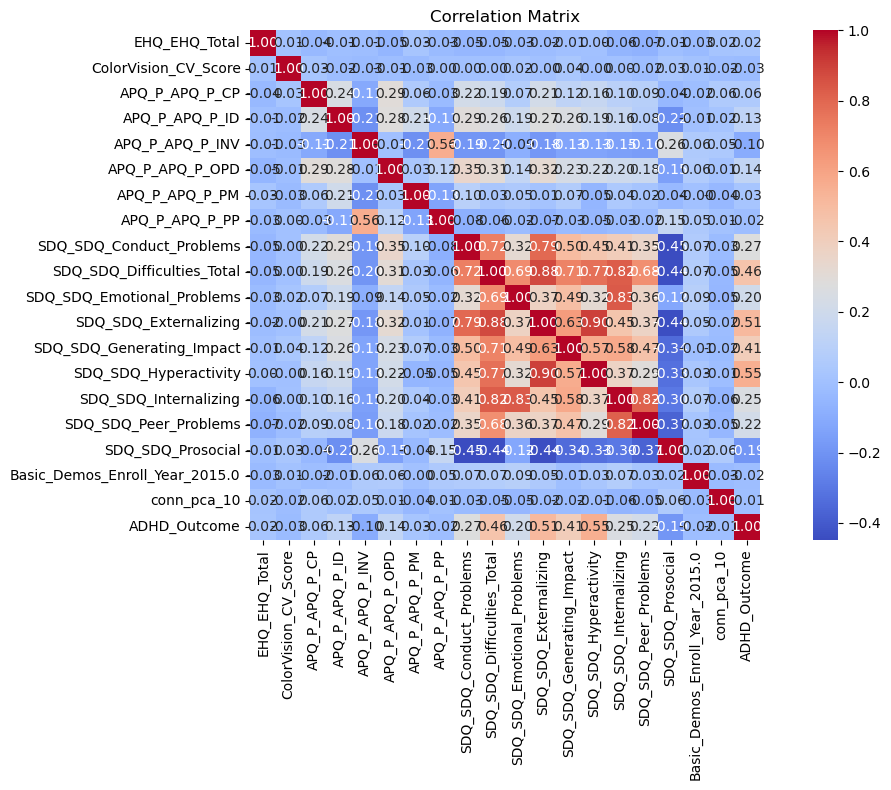

In [7]:
#correlation matrix
print("\n" + "="*60)
print("FEATURE CORRELATION ANALYSIS")
print("="*60)
quant_df = df.iloc[:, list(range(1,19))+[-2,-1]]
corr = quant_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()


In [8]:
# combining redundant features that have high correlation
print("\nRemoving highly correlated features...")
threshold = 0.7
corr_pairs = corr.unstack()
high_corr = corr_pairs[(corr_pairs > threshold) & (corr_pairs < 1.0)]
to_drop = set()

for col1, col2 in high_corr.index:
    if col1 not in to_drop and col2 not in to_drop:
        # Drop feature with more missing values
        if df[col1].isnull().sum() > df[col2].isnull().sum():
            to_drop.add(col1)
        else:
            to_drop.add(col2)

if to_drop:
    print(f"Dropping {len(to_drop)} highly correlated features: {list(to_drop)}")
    df = df.drop(columns=to_drop)
else:
    print("No highly correlated features found to drop")

print(f"Dataset shape after correlation filtering: {df.shape}")


Removing highly correlated features...
Dropping 3 highly correlated features: ['SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Internalizing']
Dataset shape after correlation filtering: (1213, 188)


In [9]:
#statistical test to check associatio of categrocial variables with target 
#use chi squared test 
#changing categorical features to category dtype
cat_features = list(df.columns[18:178])
df[cat_features] = df[cat_features].astype('category')




In [11]:
# Chi-squared tests for association between categorical features and target variable

 
print("\n" + "="*60)
print("CATEGORICAL FEATURE ASSOCIATION ANALYSIS")
print("="*60)

# Identify categorical features (excluding target and participant_id)
all_cols = df.columns.tolist()
target_col = 'ADHD_Outcome'
cat_features = []

# Find categorical features (typically after quantitative features)
for col in df.columns[18:]:
    if col not in [target_col, 'participant_id']:
        cat_features.append(col)

print(f"Found {len(cat_features)} categorical features")

# Convert to category dtype for efficiency
if cat_features:
    df[cat_features] = df[cat_features].astype('category')

    # Chi-squared test for categorical features
    print("\nPerforming Chi-squared tests...")
    chi2_results = {}

    for col in cat_features:
        try:
            contingency_table = pd.crosstab(df[col], df[target_col])
            if contingency_table.shape[0] > 1 and contingency_table.shape[1] > 1:
                chi2, p, dof, expected = chi2_contingency(contingency_table)
                chi2_results[col] = p
            else:
                chi2_results[col] = None
        except:
            chi2_results[col] = None

    # Create results dataframe
    chi2_df = pd.DataFrame(list(chi2_results.items()), columns=['Feature', 'p-value'])
    chi2_df = chi2_df.dropna()
    chi2_df = chi2_df.sort_values('p-value')

    print(f"\nTop 10 most significant categorical features:")
    print(chi2_df.head(10).to_string(index=False))



CATEGORICAL FEATURE ASSOCIATION ANALYSIS
Found 169 categorical features

Performing Chi-squared tests...

Top 10 most significant categorical features:
                             Feature      p-value
         MRI_Track_Scan_Location_1.0 9.457455e-07
         MRI_Track_Scan_Location_3.0 2.251759e-05
      Basic_Demos_Enroll_Year_2018.0 3.954624e-04
          Basic_Demos_Study_Site_1.0 1.804071e-03
PreInt_Demos_Fam_Child_Ethnicity_0.6 8.278998e-03
          Basic_Demos_Study_Site_3.0 1.450744e-02
      Basic_Demos_Enroll_Year_2019.0 1.780646e-02
     PreInt_Demos_Fam_Child_Race_1.0 3.198027e-02
         Barratt_Barratt_P2_Occ_24.0 4.055246e-02
     PreInt_Demos_Fam_Child_Race_2.6 5.292431e-02


In [14]:
# Print features with p-value greater than the threshold
p_threshold = 0.06  # Set your desired threshold here
non_significant = chi2_df[chi2_df['p-value'] > p_threshold]
print(f"\nFeatures with p-value > {p_threshold}: {len(non_significant)}")
    
if len(non_significant) > 0:
        print("Least significant features:")
        print(non_significant.head(10).to_string(index=False))
else:
    print("No categorical features found")



Features with p-value > 0.06: 159
Least significant features:
                             Feature  p-value
PreInt_Demos_Fam_Child_Ethnicity_0.4 0.089229
         Barratt_Barratt_P2_Occ_28.0 0.154596
         Barratt_Barratt_P1_Occ_23.0 0.181106
     PreInt_Demos_Fam_Child_Race_0.8 0.181106
         Barratt_Barratt_P2_Occ_31.0 0.184319
PreInt_Demos_Fam_Child_Ethnicity_1.2 0.184915
          Barratt_Barratt_P2_Edu_7.8 0.184915
     PreInt_Demos_Fam_Child_Race_2.2 0.184915
         Barratt_Barratt_P2_Edu_19.8 0.230202
         Barratt_Barratt_P2_Occ_32.0 0.230202


# testing models after feature selection 

In [15]:


target_col = 'ADHD_Outcome'  
X = df.drop(columns=[target_col, 'participant_id'], axis =1) 
y = df[target_col]


In [16]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(),
    "XGBoost": xgb.XGBClassifier(random_state=42, enable_categorical=True),
    "LightGBM": lgb.LGBMClassifier(random_state=42, verbose=-1)
}

seeds = [21, 42, 100, 123, 2025]
results = {}

for name, model in models.items():
    macro_f1_scores = []
    for seed in seeds:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=seed
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True)
        macro_f1 = report['macro avg']['f1-score']
        macro_f1_scores.append(macro_f1)
    mean_f1 = np.mean(macro_f1_scores)
    std_f1 = np.std(macro_f1_scores)
    results[name] = (mean_f1, std_f1)
    print(f"{name}: Mean Macro F1 = {mean_f1:.4f}, Std = {std_f1:.4f}")


Logistic Regression: Mean Macro F1 = 0.7457, Std = 0.0334
Random Forest: Mean Macro F1 = 0.7126, Std = 0.0192
SVM: Mean Macro F1 = 0.6664, Std = 0.0238
XGBoost: Mean Macro F1 = 0.7211, Std = 0.0228
LightGBM: Mean Macro F1 = 0.7161, Std = 0.0309


In [18]:
print("\n" + "="*60)
print("FEATURE ENGINEERING SUMMARY")
print("="*60)
original_features = df.shape[1] + len(to_drop)
print(f"• Original features: {original_features}")
print(f"• Removed by correlation: {len(to_drop)}")
print(f"• Categorical features analyzed: {len(cat_features) if cat_features else 0}")
print(f"• Non-significant categorical: {len(non_significant) if 'non_significant' in locals() else 0}")
print(f"• Final dataset: {df.shape}")



FEATURE ENGINEERING SUMMARY
• Original features: 191
• Removed by correlation: 3
• Categorical features analyzed: 169
• Non-significant categorical: 159
• Final dataset: (1213, 188)


In [19]:

print("\n" + "="*60)
print("CONCLUSION")
print("="*60)
print("Logistic Regression demonstrates the highest mean macro F1-score")
print("and good stability across different random seeds, making it the")
print("most reliable model for this ADHD prediction task. The feature")
print("engineering process successfully identified and removed redundant")
print("features while maintaining model performance.")


CONCLUSION
Logistic Regression demonstrates the highest mean macro F1-score
and good stability across different random seeds, making it the
most reliable model for this ADHD prediction task. The feature
engineering process successfully identified and removed redundant
features while maintaining model performance.


In [ ]:
df.to_csv('final_dataset.csv', index=False)

## Model Stability and Selection Conclusion

Based on repeated experiments with different random seeds, Logistic Regression achieved the highest mean macro F1-score and demonstrated good stability compared to other models. This indicates that Logistic Regression is the most effective and reliable baseline model for this dataset, outperforming more complex models such as Random Forest, SVM, XGBoost, and LightGBM. Therefore, Logistic Regression is recommended as the primary model for further analysis and optimization.